Unravelling with the V-model with just one bath

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from _utils import *
from FCS import *

In [156]:
# Define system parameters
N = 3 # Number of levels
nu = 1 # Frequency of the system
a = 0.02
delta = 0.02
# alpha = 0.5 # No right bath for now
betaL = 1/4
# betaR = 1/3.99 # No right bath for now

# Define the parameters for the V-model
params = {'nu': nu, 'a': a, 'delta': delta, 'beta': betaL}

# Set up the open system problem with one bath at temperature 1/betaL
g_ops, H_uni, c_ops_uni = V_model_1bath(**params, kind='unified')
g_ops, H_sec, c_ops_sec = V_model_1bath(**params, kind='secular')

# Define the steady state density operators
rho_ss_uni = steadystate(H_uni, c_ops_uni)
rho_ss_sec = steadystate(H_sec, c_ops_sec)

In [157]:
# We want to unravel the master equation

t0, tf = 0, 300
dt = 0.01
tlist = np.arange(t0, tf, dt)

g1, g2, g3 = g_ops

# Start the system in a pure state
# psi_init = (g2 + g3)/np.sqrt(2)
psi_init = g1
rho_init = psi_init*psi_init.dag()

# define observables 
e_ops = [g1*g1.dag(), g2*g2.dag(), g3*g3.dag(), g3*g2.dag()]

# compute the solution, here the options ntraj is the number of trajectories and noise is the seed, store_measurement saves the jumps
result_uni = photocurrent_mesolve(H_uni, rho_init, tlist, sc_ops=c_ops_uni, e_ops=e_ops, ntraj=1, noise=1, store_measurement=True)
result_sec = photocurrent_mesolve(H_sec, rho_init, tlist, sc_ops=c_ops_sec, e_ops=e_ops, ntraj=1, noise=1, store_measurement=True)

Total run time:   0.38s
Total run time:   0.45s


In [158]:
# Get all the expectation values
g1_evo_uni = result_uni.expect[0]
g2_evo_uni = result_uni.expect[1]
g3_evo_uni = result_uni.expect[2]
g32_evo_uni = result_uni.expect[3]

g1_evo_sec = result_sec.expect[0]
g2_evo_sec = result_sec.expect[1]
g3_evo_sec = result_sec.expect[2]
g32_evo_sec = result_sec.expect[3]

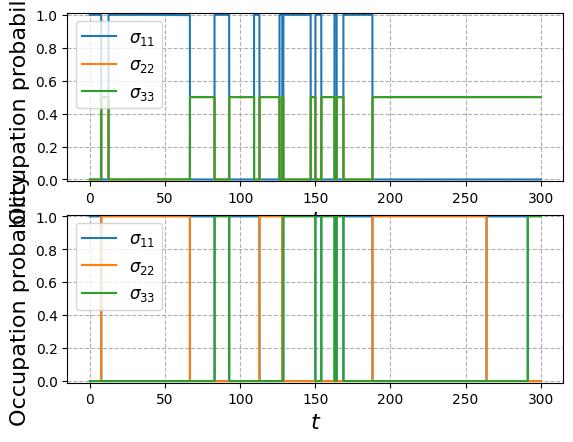

In [159]:
# Plot the populations

plt.subplot(211)
plt.plot(tlist, g1_evo_uni, label=r'$\sigma_{11}$')
plt.plot(tlist, g2_evo_uni, label=r'$\sigma_{22}$') 
plt.plot(tlist, g3_evo_uni, label=r'$\sigma_{33}$')

plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Occupation probability', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')
plt.ylim(-0.01, 1.01)

plt.subplot(212)

plt.plot(tlist, g1_evo_sec, label=r'$\sigma_{11}$')
plt.plot(tlist, g2_evo_sec, label=r'$\sigma_{22}$') 
plt.plot(tlist, g3_evo_sec, label=r'$\sigma_{33}$')

plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Occupation probability', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')

plt.ylim(-0.01, 1.01)

plt.show()

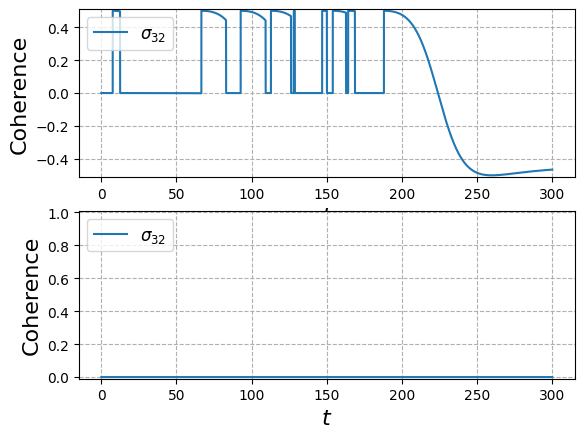

In [160]:
# Plot the coherences

plt.subplot(211)
plt.plot(tlist, g32_evo_uni, label=r'$\sigma_{32}$')

plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Coherence', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')
plt.ylim(-0.511, 0.51)

plt.subplot(212)

plt.plot(tlist, g32_evo_sec, label=r'$\sigma_{32}$')

plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Coherence', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')

plt.ylim(-0.01, 1.01)

plt.show()

In [161]:
# Let's build the non-conditional density operator by averaging over an ensemble of trajectories, for comparison to the solution of the QME
# Unified only, we know the secular equation will give simple behaviour for the coherence

N = 100 # Number of trajectories in the ensemble

# compute the solution, here the options ntraj is the number of trajectories and noise is the seed, store_measurement saves the jumps
result_uni_ensemble = photocurrent_mesolve(H_uni, rho_init, tlist, sc_ops=c_ops_uni, e_ops=e_ops, ntraj=200, noise=1, store_measurement=True)

10.0%. Run time:   8.01s. Est. time left: 00:00:01:12
20.0%. Run time:  14.14s. Est. time left: 00:00:00:56
30.0%. Run time:  20.13s. Est. time left: 00:00:00:46
40.0%. Run time:  24.59s. Est. time left: 00:00:00:36
50.0%. Run time:  29.11s. Est. time left: 00:00:00:29
60.0%. Run time:  33.62s. Est. time left: 00:00:00:22
70.0%. Run time:  38.44s. Est. time left: 00:00:00:16
80.0%. Run time:  43.27s. Est. time left: 00:00:00:10
90.0%. Run time:  48.02s. Est. time left: 00:00:00:05
Total run time:  52.79s


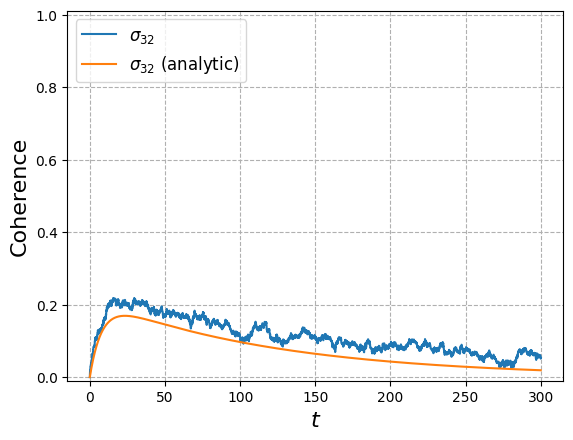

In [164]:
# Plot coherence for the ensemble


g32_evo_uni_ensemble = result_uni_ensemble.expect[3]

# Analytic solution (from Felix's work)
k = a*nu*BoseEinsteinDistribution(nu,betaL)
phi = k*(1 + 2*np.exp(-betaL*nu))
tau = (2*k*(1+np.exp(-betaL*nu)))/(delta**2*(1 + 2*np.exp(-betaL*nu)))
g32_analytic = ((phi - k)/(2*(phi + k)))*(np.exp(-tlist/tau)-np.exp(-(phi + k)*tlist))



plt.figure()
plt.plot(tlist, g32_evo_uni_ensemble, label=r'$\sigma_{32}$')
plt.plot(tlist, g32_analytic, label=r'$\sigma_{32}$ (analytic)')
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Coherence', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')
plt.ylim(-0.01, 1.01)



plt.show()